# Seasonal analysis of Tip-Jet events


This notebook focuses on the study of global warming's impact on Tip-Jets seasonality. Tip-Jets have a more significant effect in summer or fall due to higher temperatures, causing increased ice melt and resulting in fresher water. This leads to a greater impact on water circulation in the North Atlantic.
<br><br>
As observed in the notebook `climate_change_impact_on_tip_jet_frequency_intensity.ipynb`, the frequency of Tip-Jets will likely increase in a high emission scenario. However, it is essential to determine whether there is an increasing occurrence of Tip-Jets in summer/fall.

In [1]:
# Install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.7/200.7 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=Shapely-1.8.5-cp310-cp310-linux_x86_64.whl size=832078 sha256=3d51c4743e57e0c708a1ebf1b12b36496412179dea8043600bbb67a6d6ac05d0
  Stored in directory: /root/.cache/pip/wheels/4b/90/0f/3b3770cbfdb258547dc55f689c7287d8408730f01979e7e234
Successfully built shapely
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [52]:
from tip_jet_detection import Ensemble
from tabulate import tabulate
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# gcsfs to read data from online storage
import gcsfs
# sklearn for the EOF decomposition
from sklearn.decomposition import PCA
# mit to find consecutive numbers in a given list
import more_itertools as mit
# cartopy to plot geographical maps
import cartopy.crs as ccrs
# pyproj to compute clean distance between longitudes and latitudes
from pyproj import Geod
from ipywidgets import interact

g = Geod(ellps='WGS84')

We have gathered multiple available members for the analysis, considering both the worst-case scenario (with a forcing of 8.5 W/m²) and the best-case scenario (with a forcing of 2.6 W/m²). Retrieving several members is crucial due to the chaotic nature of the climate.
<br>
Upon examination, it becomes evident that the current number of members is insufficient to effectively average the results, given the persistent high random noise in the time series. Unfortunately, there are no additional members accessible for the model we are utilizing. Even if we had more members, their inclusion in our analysis would be challenging, primarily due to the extensive computation time required.

In [3]:
# initialising the different members of scenrio ssp126
ens_126 = Ensemble(list_of_member = ['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r6i1p1f1','r14i1p1f1'], experiment='ssp126')
# initialising the different members of scenrio ssp585
ens_585 = Ensemble(list_of_member = ['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r14i1p1f1'], experiment='ssp585')

We first retrieve the mean seasonal number of Tip-Jets for each year and for the two scenarios

In [34]:
seasonal_mean_tip_jet_126, seasonal_std_tip_jet_126 = ens_126.mean_seasonal_events_ensemble()
seasonal_mean_tip_jet_585, seasonal_std_tip_jet_585 = ens_585.mean_seasonal_events_ensemble()

In [35]:
# Retriving seasonal data for both scenarios

winter_126 = seasonal_mean_tip_jet_126[:,0]
spring_126 = seasonal_mean_tip_jet_126[:,1]
summer_126 = seasonal_mean_tip_jet_126[:,2]
fall_126 = seasonal_mean_tip_jet_126[:,3]

winter_585 = seasonal_mean_tip_jet_585[:,0]
spring_585 = seasonal_mean_tip_jet_585[:,1]
summer_585 = seasonal_mean_tip_jet_585[:,2]
fall_585 = seasonal_mean_tip_jet_585[:,3]

## Focus on the scenario with a forcing of 2.6W/m²

From the following plot, it is difficult to determine whether there is an increase or decrease in Tip-Jet events for any given season. However, it appears that the number of Tip-Jet events is decreasing over time.

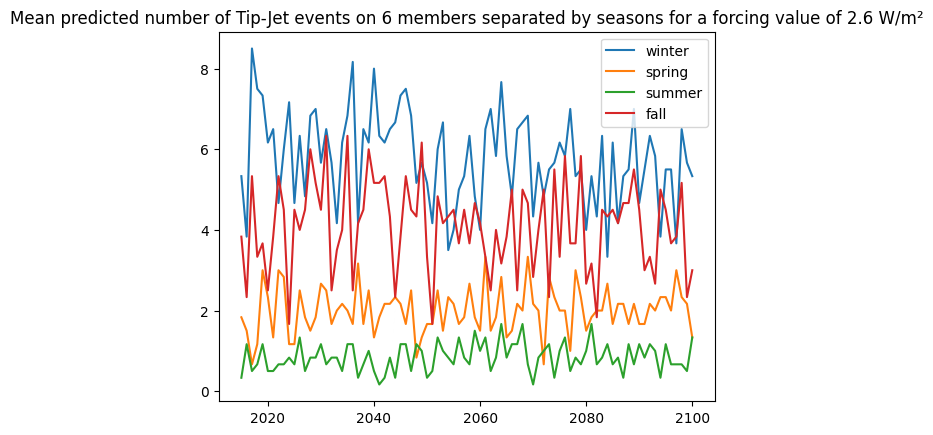

In [36]:
plt.plot(np.arange(2015, 2101), winter_126, label="winter")
plt.plot(np.arange(2015, 2101), spring_126, label="spring")
plt.plot(np.arange(2015, 2101), summer_126, label="summer")
plt.plot(np.arange(2015, 2101), fall_126, label="fall")
plt.title("Mean predicted number of Tip-Jet events on 6 members separated by seasons for a forcing value of 2.6 W/m²")
plt.legend()

To obtain smoother curves, we will use a moving average on the data. We lose a little of the meaning of the data, but it helps us to better understand the seasonal trend in Tip-Jet occurrences.

In [37]:
# Convert data to a numpy array for both scenarios
winter_126_df = pd.Series(winter_126)
spring_126_df = pd.Series(spring_126)
summer_126_df = pd.Series(summer_126)
fall_126_df = pd.Series(fall_126)

winter_585_df = pd.Series(winter_585)
spring_585_df = pd.Series(spring_585)
summer_585_df = pd.Series(summer_585)
fall_585_df = pd.Series(fall_585)

# Set the window size (the new value will be an average of its n-1 closest neighbours and itself)
window_size = 7

# Use moving average to obtain smoother curves
winter_126_rolled = winter_126_df.rolling(window=window_size, min_periods=3, center=True).mean()
spring_126_rolled = spring_126_df.rolling(window=window_size, min_periods=3, center=True).mean()
summer_126_rolled = summer_126_df.rolling(window=window_size, min_periods=3, center=True).mean()
fall_126_rolled = fall_126_df.rolling(window=window_size, min_periods=3, center=True).mean()

winter_585_rolled = winter_585_df.rolling(window=window_size, min_periods=3, center=True).mean()
spring_585_rolled = spring_585_df.rolling(window=window_size, min_periods=3, center=True).mean()
summer_585_rolled = summer_585_df.rolling(window=window_size, min_periods=3, center=True).mean()
fall_585_rolled = fall_585_df.rolling(window=window_size, min_periods=3, center=True).mean()

With the plot bellow (showing the result of the use of moving average on the mean predicted number of Tip-Jet events) we observe a slight decrease on the number of Tip-Jet events in winter for the best scenario.

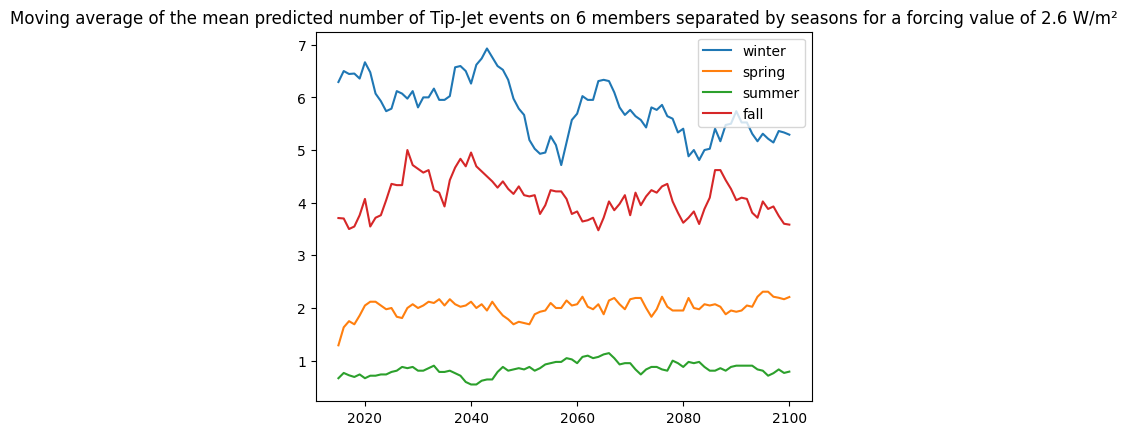

In [38]:
plt.plot(np.arange(2015, 2101), winter_126_rolled, label="winter")
plt.plot(np.arange(2015, 2101), spring_126_rolled, label="spring")
plt.plot(np.arange(2015, 2101), summer_126_rolled, label="summer")
plt.plot(np.arange(2015, 2101), fall_126_rolled, label="fall")
plt.title("Moving average of the mean predicted number of Tip-Jet events on 6 members separated by seasons for a forcing value of 2.6 W/m²")
plt.legend()

## Focus on the scenario with a forcing of 8.5W/m²

Same as before, it is hard to conclude on global trend for Tip-Jets frequency as data still have an important noise so we will use again moving average.

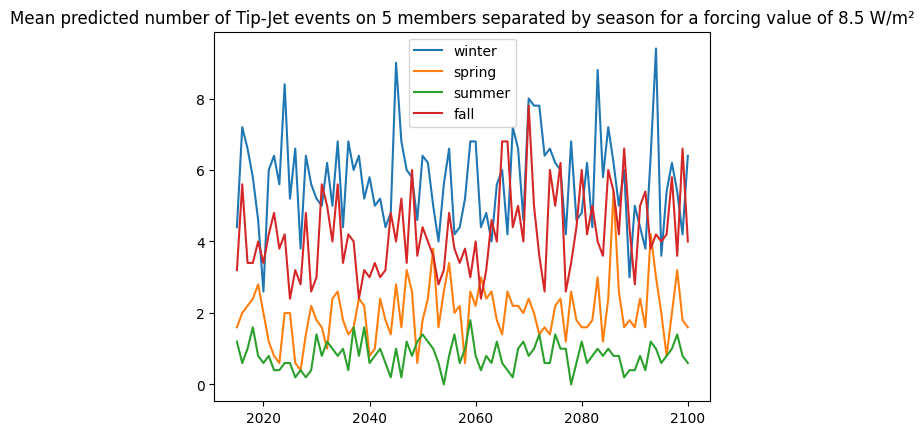

In [39]:
plt.plot(np.arange(2015, 2101), winter_585, label="winter")
plt.plot(np.arange(2015, 2101), spring_585, label="spring")
plt.plot(np.arange(2015, 2101), summer_585, label="summer")
plt.plot(np.arange(2015, 2101), fall_585, label="fall")
plt.title("Mean predicted number of Tip-Jet events on 5 members separated by season for a forcing value of 8.5 W/m²")
plt.legend()

We can see from the plot bellow that with higher emissions, the number of Tip-Jet events does not seem to decrease in winter. Fall seems to be the season where Tip-Jet events is increasing the more.

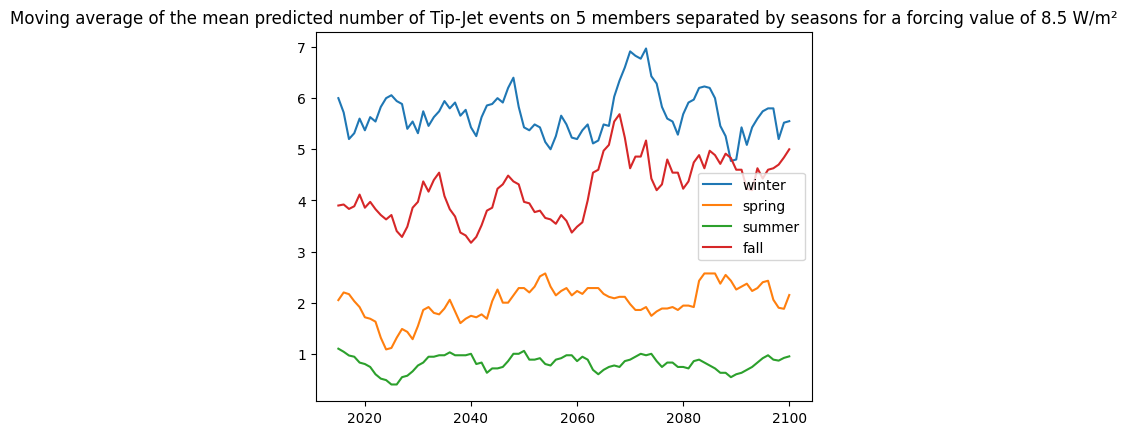

In [40]:
plt.plot(np.arange(2015, 2101), winter_585_rolled, label="winter")
plt.plot(np.arange(2015, 2101), spring_585_rolled, label="spring")
plt.plot(np.arange(2015, 2101), summer_585_rolled, label="summer")
plt.plot(np.arange(2015, 2101), fall_585_rolled, label="fall")
plt.title("Moving average of the mean predicted number of Tip-Jet events on 5 members separated by seasons for a forcing value of 8.5 W/m²")
plt.legend()

## Comparison of the two scenarios : SSP126 and SSP585

Again, noisy data is hard to handle, plots are difficult to interpret.

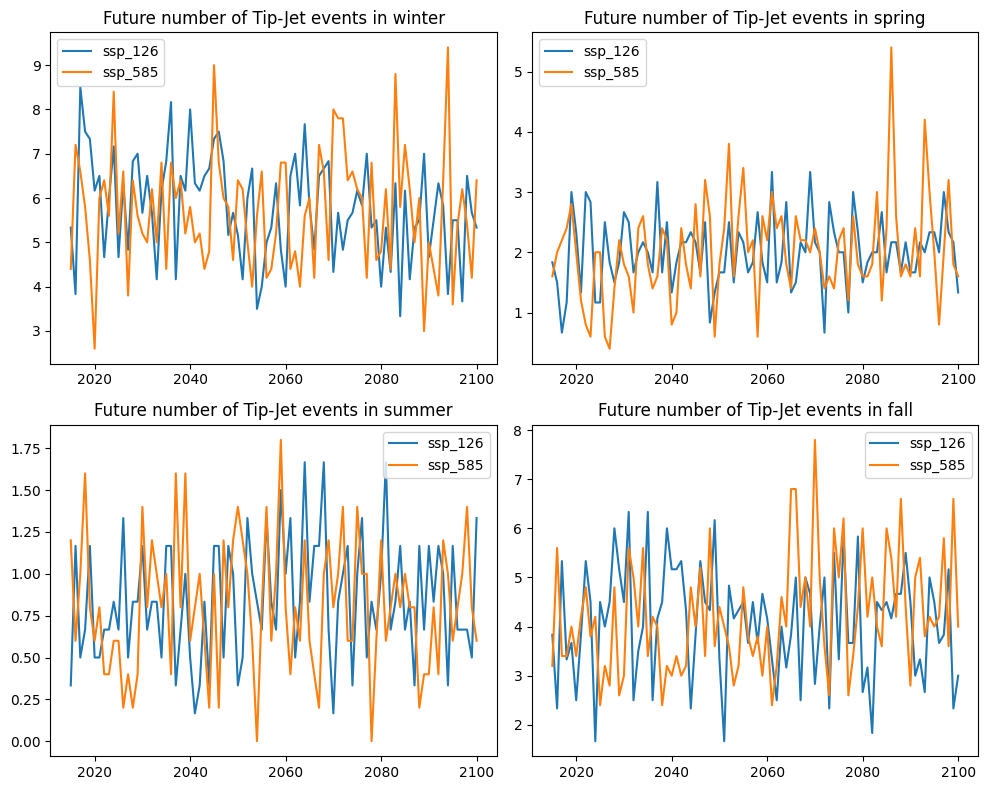

In [41]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot for Winter
axs[0, 0].plot(np.arange(2015, 2101), winter_126, label="ssp_126")
axs[0, 0].plot(np.arange(2015, 2101), winter_585, label="ssp_585")
axs[0, 0].set_title('Future number of Tip-Jet events in winter')
axs[0, 0].legend()

# Plot for Spring
axs[0, 1].plot(np.arange(2015, 2101), spring_126, label="ssp_126")
axs[0, 1].plot(np.arange(2015, 2101), spring_585, label="ssp_585")
axs[0, 1].set_title('Future number of Tip-Jet events in spring')
axs[0, 1].legend()

# Plot for Summer
axs[1, 0].plot(np.arange(2015, 2101), summer_126, label="ssp_126")
axs[1, 0].plot(np.arange(2015, 2101), summer_585, label="ssp_585")
axs[1, 0].set_title('Future number of Tip-Jet events in summer')
axs[1, 0].legend()

# Plot for Fall
axs[1, 1].plot(np.arange(2015, 2101), fall_126, label="ssp_126")
axs[1, 1].plot(np.arange(2015, 2101), fall_585, label="ssp_585")
axs[1, 1].set_title('Future number of Tip-Jet events in fall')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

Using moving average, we confirm our hypothesis, during winter, the number of Tip-Jets is expected to decrease with low emissions and the number of Tip-Jets is expected to increase in a world with high emissions. We also see that in spring, the number of Tip-Jets is slighlty increasing with high emissions.

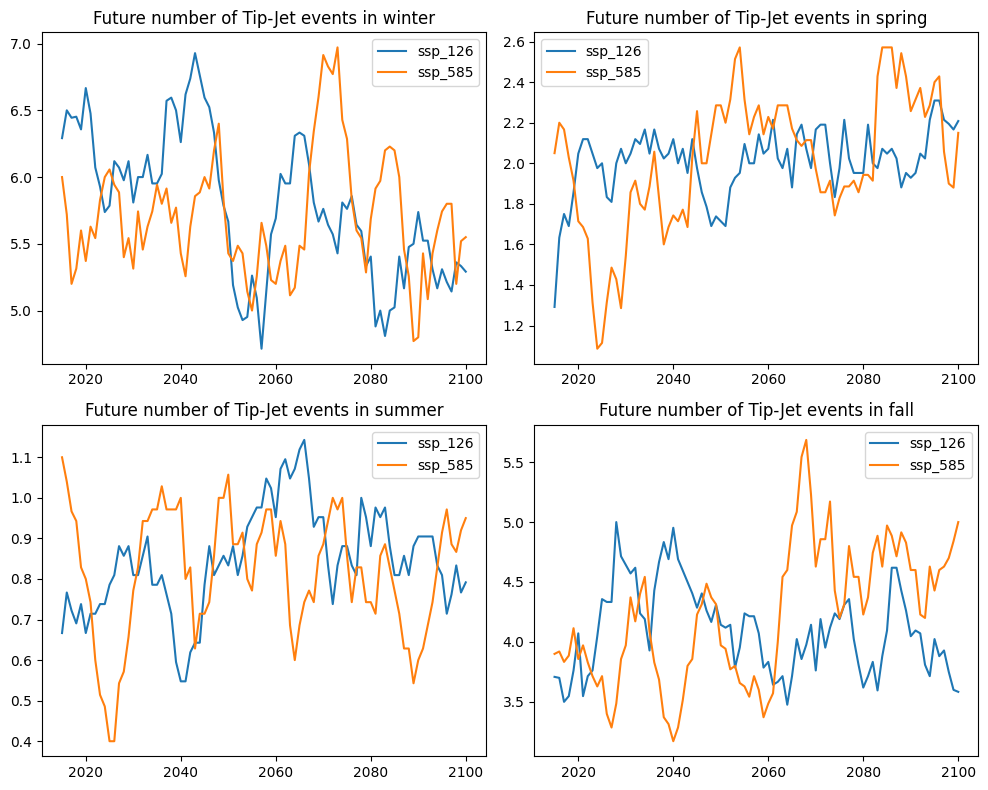

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot for Winter
axs[0, 0].plot(np.arange(2015, 2101), winter_126_rolled, label="ssp_126")
axs[0, 0].plot(np.arange(2015, 2101), winter_585_rolled, label="ssp_585")
axs[0, 0].set_title('Future number of Tip-Jet events in winter')
axs[0, 0].legend()

# Plot for Spring
axs[0, 1].plot(np.arange(2015, 2101), spring_126_rolled, label="ssp_126")
axs[0, 1].plot(np.arange(2015, 2101), spring_585_rolled, label="ssp_585")
axs[0, 1].set_title('Future number of Tip-Jet events in spring')
axs[0, 1].legend()

# Plot for Summer
axs[1, 0].plot(np.arange(2015, 2101), summer_126_rolled, label="ssp_126")
axs[1, 0].plot(np.arange(2015, 2101), summer_585_rolled, label="ssp_585")
axs[1, 0].set_title('Future number of Tip-Jet events in summer')
axs[1, 0].legend()

# Plot for Fall
axs[1, 1].plot(np.arange(2015, 2101), fall_126_rolled, label="ssp_126")
axs[1, 1].plot(np.arange(2015, 2101), fall_585_rolled, label="ssp_585")
axs[1, 1].set_title('Future number of Tip-Jet events in fall')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [68]:
def plot_diff_scenarios_585_126_2(show_winter=True, show_spring=True, show_summer=True, show_fall=True):
    if show_winter:
        plt.plot(winter_585_rolled - winter_126_rolled, label="winter")
    if show_spring:
        plt.plot(spring_585_rolled - spring_126_rolled, label="spring")
    if show_summer:
        plt.plot(summer_585_rolled - summer_126_rolled, label="summer")
    if show_fall:
        plt.plot(fall_585_rolled - fall_126_rolled, label="fall")
    plt.ylim(bottom=-2, top=2)

    plt.title("Difference of the seasonal moving average of the mean number of Tip-Jet events on the worst and best scenario")
    plt.legend()
    plt.show()

# Create interactive buttons
interact(plot_diff_scenarios_585_126_2, show_winter=True, show_spring=True, show_summer=True, show_fall=True)

interactive(children=(Checkbox(value=True, description='show_winter'), Checkbox(value=True, description='show_…

<function __main__.plot_diff_scenarios_585_126_2(show_winter=True, show_spring=True, show_summer=True, show_fall=True)>

### Conducting linear regression to assess the relevance of trends.

In [61]:
# Function to perform linear regression and return slope and R² score as a string

def perform_linear_regression(x, y):
    model = LinearRegression()
    model.fit(x, y)
    slope = model.coef_[0][0]
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    return f"Slope: {round(slope,2)} ; R² score: {round(r2,2)}"

In [65]:
# Reshape the data because we have 1D arrays

# To sutudy the slope, we "normalize" years so that for instance, a slope of 2
# means that there will be twice as many Tip-jets in 2100 as in 2015. If we do
# not do it, the slope coefficient will be very small
temp = np.linspace(0, 1, 2101-2015)
temp_reshaped = temp.reshape(-1, 1)

# Convert pandas Series to NumPy arrays
winter_585_rolled_reshaped = winter_585_rolled.to_numpy().reshape(-1, 1)
winter_126_rolled_reshaped = winter_126_rolled.to_numpy().reshape(-1, 1)

spring_585_rolled_reshaped = spring_585_rolled.to_numpy().reshape(-1, 1)
spring_126_rolled_reshaped = spring_126_rolled.to_numpy().reshape(-1, 1)

summer_585_rolled_reshaped = summer_585_rolled.to_numpy().reshape(-1, 1)
summer_126_rolled_reshaped = summer_126_rolled.to_numpy().reshape(-1, 1)

fall_585_rolled_reshaped = fall_585_rolled.to_numpy().reshape(-1, 1)
fall_126_rolled_reshaped = fall_126_rolled.to_numpy().reshape(-1, 1)

# Perform linear regression for each season and store results in a table
table_data = []

seasons = ["Winter", "Spring", "Summer", "Fall"]
for season_name, x, y_126, y_585 in zip(seasons,
                                       [temp_reshaped]*4,
                                       [winter_126_rolled_reshaped, spring_126_rolled_reshaped,
                                        summer_126_rolled_reshaped, fall_126_rolled_reshaped],
                                       [winter_585_rolled_reshaped, spring_585_rolled_reshaped,
                                        summer_585_rolled_reshaped, fall_585_rolled_reshaped]):
    forcing_2_6 = perform_linear_regression(x, y_126)
    forcing_8_5 = perform_linear_regression(x, y_585)

    table_data.append([season_name, forcing_2_6, forcing_8_5])

# Print the table
headers = ["Season", "Forcing 2.6W/m²", "Forcing 8.5W/m²"]
table = tabulate(table_data, headers, tablefmt="fancy_grid")
print(table)


╒══════════╤═══════════════════════════════╤═════════════════════════════╕
│ Season   │ Forcing 2.6W/m²               │ Forcing 8.5W/m²             │
╞══════════╪═══════════════════════════════╪═════════════════════════════╡
│ Winter   │ Slope: -1.19 ; R² score: 0.42 │ Slope: 0.03 ; R² score: 0.0 │
├──────────┼───────────────────────────────┼─────────────────────────────┤
│ Spring   │ Slope: 0.22 ; R² score: 0.16  │ Slope: 0.63 ; R² score: 0.3 │
├──────────┼───────────────────────────────┼─────────────────────────────┤
│ Summer   │ Slope: 0.16 ; R² score: 0.15  │ Slope: 0.0 ; R² score: 0.0  │
├──────────┼───────────────────────────────┼─────────────────────────────┤
│ Fall     │ Slope: -0.29 ; R² score: 0.06 │ Slope: 1.22 ; R² score: 0.4 │
╘══════════╧═══════════════════════════════╧═════════════════════════════╛


By the result of the linear regression, we see that the models with the highest R² score are related to:


*   The number of Tip-Jet events occuring in winter with the scenario having a forcing of 2.6W/m² (slope -1.19)
*   The number of Tip-Jet events occuring in fall with the scenario having a forcing of 8.5W/m² (slope 1.22)

This indeed show that if we control global warming, it may result in a diminution of Tip-Jet events in winter which is not the case otherwise. It also shows that by polluting more and more, Tip-Jet events may be more frequent in fall but also, less significantly, in spring.